This notebook will allow you to mock up an emission line spectrum of Hbeta + [OIII] given the metallicity and redshift.

In [18]:
# user parameters

z = 6.0 # redshift of your galaxy
R = 1500 # spectral resolution (e.g. this is NIRCam GRISM)
sigma = 0.01 # line width in microns
snr = 10.0 # SNR of the mock spectrum

metalArr = [5.5, 6.0, 6.5, 7.0] # array of desired metallicities, in 12 + log(O/H)

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import cmasher as cmr
from scipy.interpolate import interp1d

plt.rc('text',usetex=True)
font = {'family':'sans-serif','sans-serif':['Helvetica'],'size':10}
plt.rc('font',**font)
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.handletextpad'] = 1
plt.rcParams['figure.dpi'] = 150


# observed wavelengths of emission lines; converted to microns
waveHb = 4861.0*(1+z)/10000
waveOIII4959 = 4959.0*(1+z)/10000
waveOIII5007 = 5007.0*(1+z)/10000

# calculate gaussian line profile given the total line flux
def gaussian(x, mu, sigma, flux):
    amplitude = flux/(sigma*np.sqrt(2*np.pi))
    return amplitude*np.exp(-(x-mu)**2/(2*sigma**2))

# get composite line profile given the R3 ratio ([OIII]5007 to Hbeta integrated flux ratio)
def getLines(R3, wl, flux_hb=1.0):

    fluxOIII5007 = R3 * flux_hb
    fluxOIII4959 = fluxOIII5007/3.0

    yHb = gaussian(wl, waveHb, sigma, flux_hb)
    yOIII4959 = gaussian(wl, waveOIII4959, sigma, fluxOIII4959)
    yOIII5007 = gaussian(wl, waveOIII5007, sigma, fluxOIII5007)
    yTot = yHb + yOIII4959 + yOIII5007

    return yTot, yHb, yOIII4959, yOIII5007

# convert metallicity to R3 (here you ideally want to run CLOUDY for your specific conditions, but as an example here I am taking the curve from Morishita+25 Fig. 3, logU=-0.5)
def metalToR3(metal):

    rel = np.loadtxt('Morishita+25logU-0.5.txt',delimiter=',')
    relMetal = rel[:,0]
    relR3 = rel[:,1]

    interp = interp1d(relMetal,relR3,kind='linear',bounds_error=False, fill_value='extrapolate')

    R3 = 10**interp(metal) # note the relation is between metallicity and logR3

    return R3

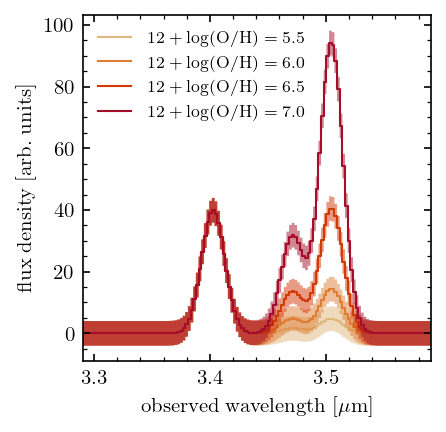

In [51]:
# construct wavelength array
wlMin, wlMax = 4500*(1+z)/10000, 5350*(1+z)/10000  # wavelength coverage (in microns)
wlCenter = 0.5*(wlMin + wlMax)
wl = np.arange(wlMin, wlMax, wlCenter/R)

N = len(metalArr)
cmap = cmr.sunburst_r
colArr = [cmap(i) for i in np.linspace(0.2, 0.6, N)]

plt.figure(figsize=(3.0,3.0))
plt.xlim(0.47*(1+z),0.513*(1+z))

for m, metal in enumerate(metalArr):
    R3 = metalToR3(metal)
    y_total, yHb, _, _ = getLines(R3, wl)
    noise = np.max(yHb)/snr # mock up approx uncertainty
    plt.step(wl, y_total, color=colArr[m], lw=1, label=fr'$12 + \log(\mathrm{{O/H}}) = {metal}$', zorder=1, where='mid')
    plt.fill_between(wl, y_total-noise, y_total+noise, color=colArr[m], alpha=0.5, step='mid', zorder=1, lw=0)

plt.legend(frameon=False,fontsize=8)
plt.xlabel(r'${\rm observed\ wavelength\ [\mu m] }$')
plt.ylabel(r'${\rm flux\ density\ [arb.\ units] }$')

plt.savefig('HbOIIIemission.pdf',bbox_inches='tight',dpi=400)
plt.savefig('HbOIIIemission.png',bbox_inches='tight',dpi=400)